In [1]:
from src.dataset_segmented import AnimeAudioDataset
import torch
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import AdaBoostClassifier
import pickle

In [2]:
# IMPORTANT: Remember the features and other data are not normalized. Check dataset_segmented.

# Load data

In [3]:
data = AnimeAudioDataset()

Boku_no_Hero_Academia_10
Death_Note_21
Haikyuu!!_23
Death_Note_35
Kimetsu_no_Yaiba_23
Made_in_Abyss_7
Vinland_Saga_17
Mob_Pyscho_100_4
Cowboy_Bebop_5
Vinland_Saga_1
Haikyuu!!_8
One_Punch_Man_9
Made_in_Abyss_5
Kimetsu_no_Yaiba_24
Haikyuu!!_13
One_Punch_Man_5
Haikyuu!!_10
Cowboy_Bebop_7
Kimetsu_no_Yaiba_10
Kimetsu_no_Yaiba_2
Yakusoku_no_Neverland_5
Kimetsu_no_Yaiba_8
One_Punch_Man_4
Death_Note_31
Shingeki_no_Kyojin_21
One_Punch_Man_7
Haikyuu!!_3
Haikyuu!!_6
Vinland_Saga_5
Vinland_Saga_24
Haikyuu!!_4
Boku_Dake_ga_inai_Machi_9
Death_Note_23
Cowboy_Bebop_4
Made_in_Abyss_12
Boku_Dake_ga_inai_Machi_2
Yakusoku_no_Neverland_2
Cowboy_Bebop_18
Made_in_Abyss_11
Shingeki_no_Kyojin_11
Shingeki_no_Kyojin_1
Mob_Pyscho_100_1
Boku_no_Hero_Academia_3
Shigatsu_wa_kimi_no_Uso_10
Kimetsu_no_Yaiba_14
Vinland_Saga_22
Haikyuu!!_21
Vinland_Saga_16
Vinland_Saga_19
Cowboy_Bebop_9
Death_Note_16
Shingeki_no_Kyojin_2
Kimetsu_no_Yaiba_20
Kimetsu_no_Yaiba_16
Haikyuu!!_5
Death_Note_18
Made_in_Abyss_8
Mob_Pyscho_100_2
K

In [6]:
len(data.labels96)

175

# Visualize all data points

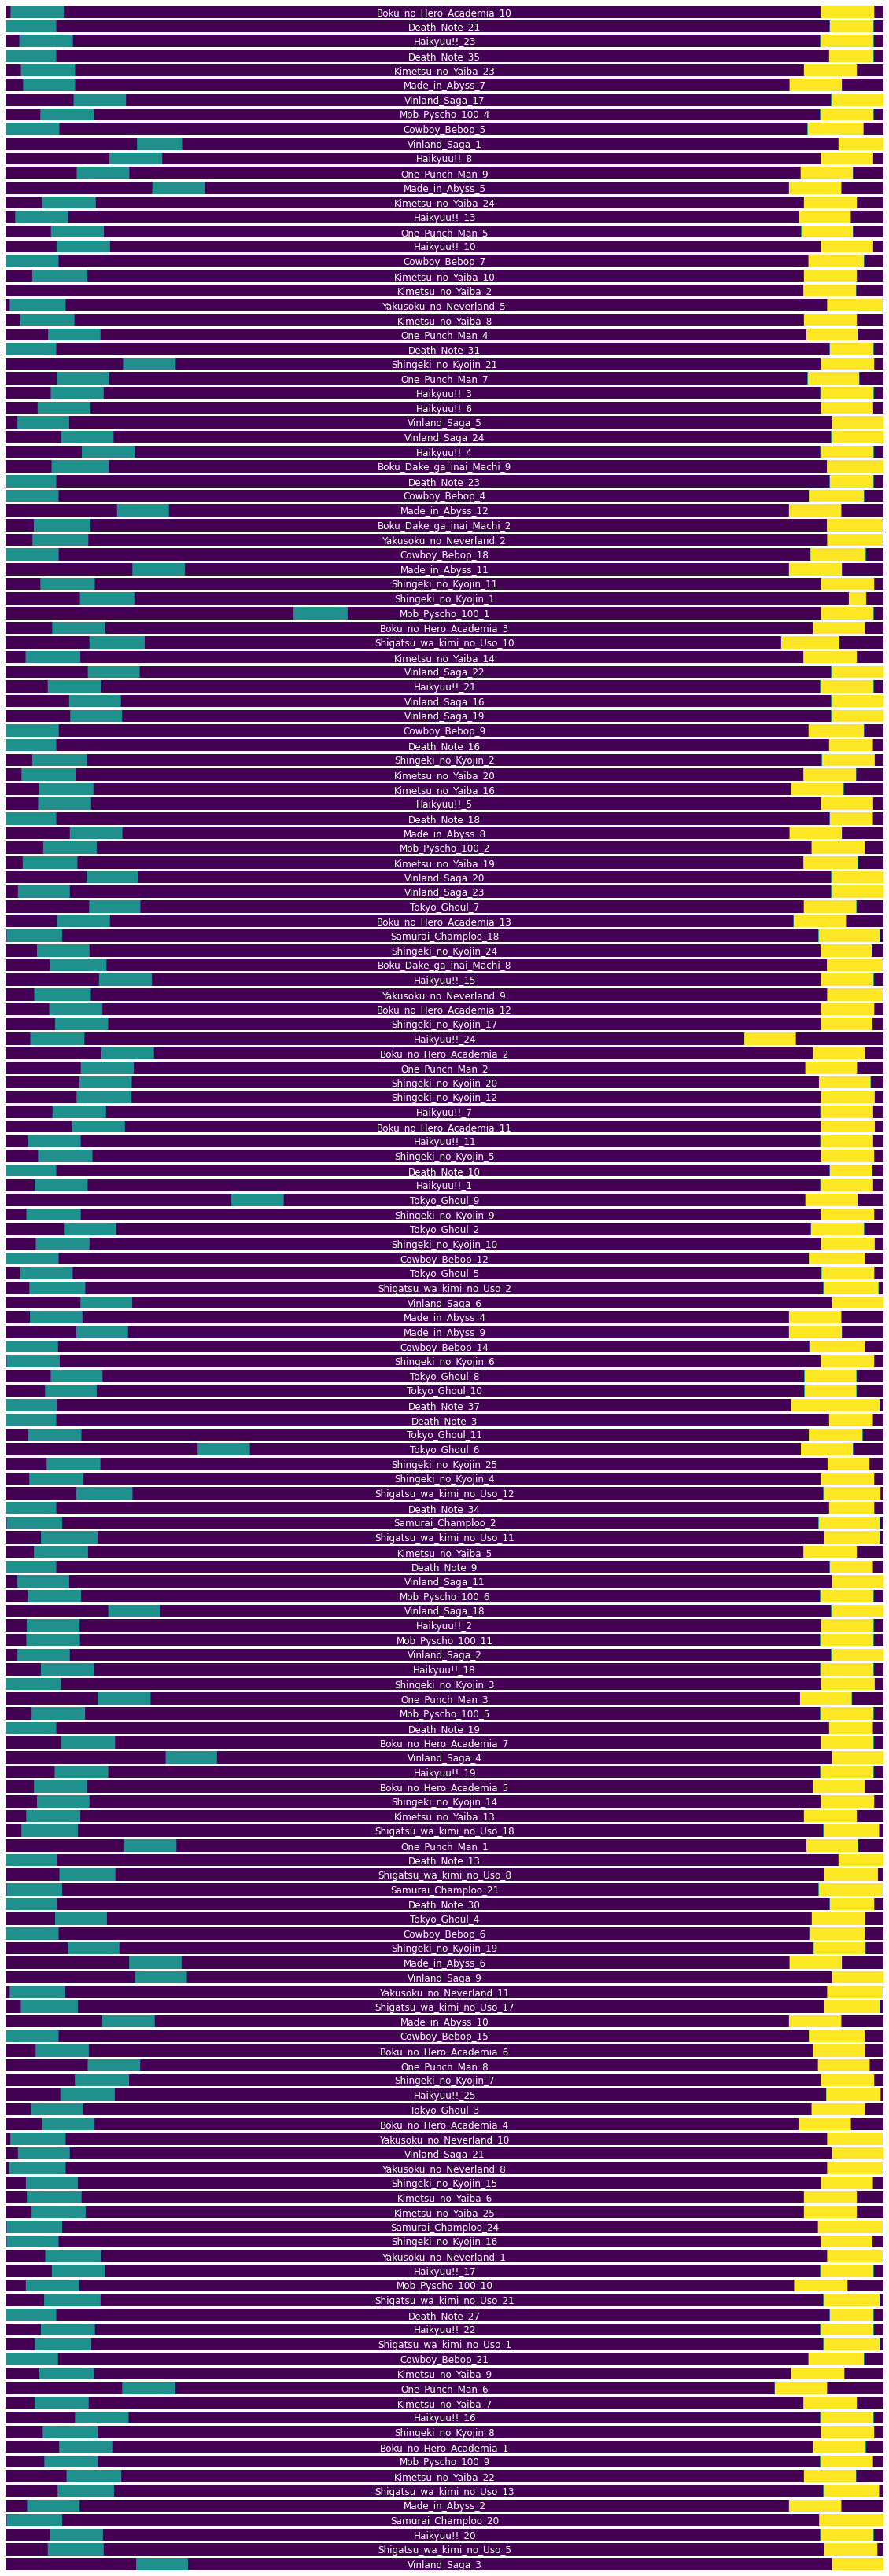

In [5]:
import matplotlib.pyplot as plt

width=20
height=60
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['text.color'] = 'white'
# plt.axis('off')
axes=[]
fig=plt.figure()

i=0
for a in data.labels96:
    axes.append( fig.add_subplot(len(data.labels96),1, i+1) )
    subplot_title=(a)
    axes[-1].set_title(subplot_title, y=-.2)  
    plt.imshow(np.array(data.labels96[a]).reshape((1,-1)), aspect='auto')
    plt.axis('off')
    i += 1   
plt.show()

# example of a audio slice (960 ms)

In [6]:
# feature, mel-spectrogram (log), labels, time, labels96
# labels is the 4 ms stamps of intro and outro
# labels96 is [x, ...] : x being 0,1,2 for noninout,intro,outro respectively
f, m, l, t, l96 = data.get_all('Boku_no_Hero_Academia_10')

In [7]:
# size of mel-spectrogram
m[0].size()

torch.Size([1, 96, 64])

In [8]:
# size of feature vector
f[0].size()

torch.Size([128])

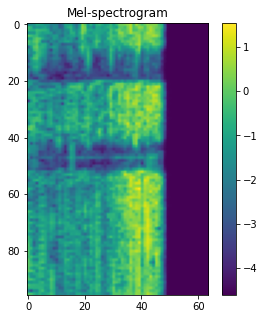

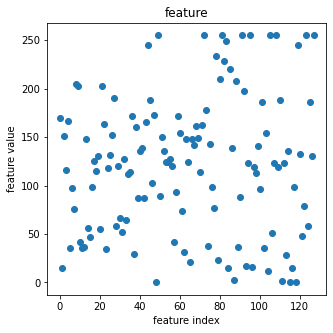

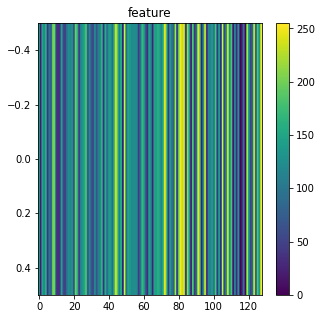

In [9]:
plt.rcParams['text.color'] = 'black'
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(m[10][0].detach().numpy())
plt.title('Mel-spectrogram')
plt.colorbar()
plt.show()
plt.scatter(np.arange(128),f[0].cpu().numpy())
plt.title('feature')
plt.xlabel('feature index')
plt.ylabel('feature value')
plt.show()
plt.imshow(f[0].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.title('feature')
plt.colorbar()
plt.show()

# Averaging

In [10]:
def show(m, f):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.title('Mel-spectrogram')
    plt.imshow(m)
    plt.show()
    plt.title('feature')
    plt.xlabel('feature index')
    plt.ylabel('feature value')
    plt.scatter(np.arange(128),f)
    plt.show()
    plt.title('feature')
    plt.imshow(f.reshape((1,-1)), aspect='auto')
    plt.show()

In [11]:
def visualize(key):
    f, m, l, t, l96 = data.get_all(key)
    m_n = np.zeros((96,64))
    f_n = np.zeros((128))
    ncount = 0
    m_i = np.zeros((96,64))
    f_i = np.zeros((128))
    icount = 0
    m_o = np.zeros((96,64))
    f_o = np.zeros((128))
    ocount = 0

    segments = f.size()[0]
    for i in range(segments):
        # first and last 2 seconds tend to be outliers
        if i == 0 or i == 1:
            continue
        if i == segments or i == segments-1:
            continue

        if l96[i] == 0: # normal
            m_n += m[i][0].detach().numpy()
            f_n += f[i].cpu().numpy()
            ncount += 1
        elif l96[i] == 1: # intro
            m_i += m[i][0].detach().numpy()
            f_i += f[i].cpu().numpy()
            icount += 1
        elif l96[i] == 2: # outro
            m_o += m[i][0].detach().numpy()
            f_o += f[i].cpu().numpy()
            ocount += 1

    m_n /= ncount
    f_n /= ncount
    m_i /= icount
    f_i /= icount
    m_o /= ocount
    f_o /= ocount

    print ('normal')
    show(m_n,f_n)
    print ('intro')
    show(m_i,f_i)
    print ('outtro')
    show(m_o,f_o)

## average of normal, intro, and outtro

I plotted this so that I could maybe find some distinguishable visual differences to get some insight. I divided the data into audio slices of outro, intro, and neither (which I called normal).

normal


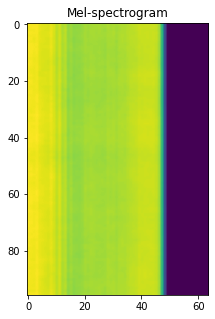

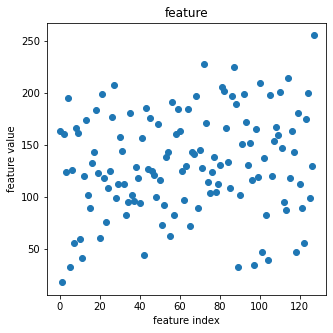

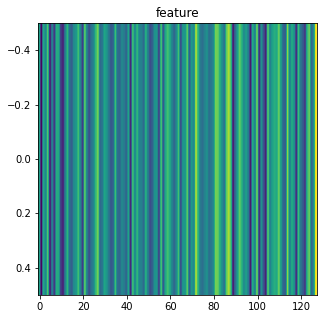

intro


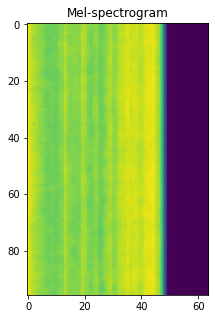

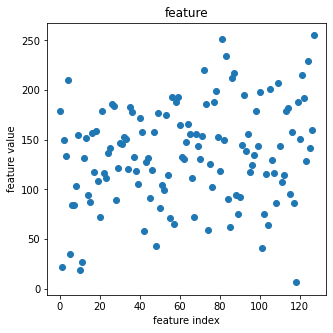

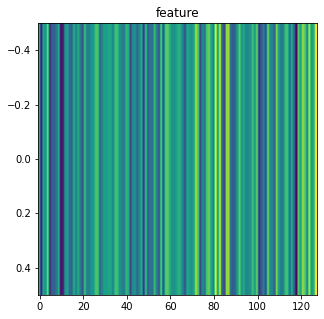

outtro


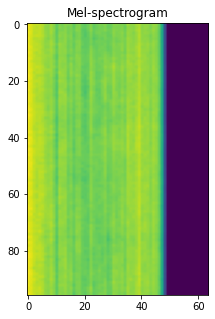

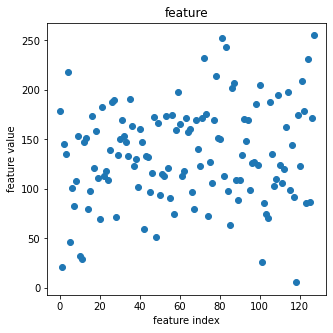

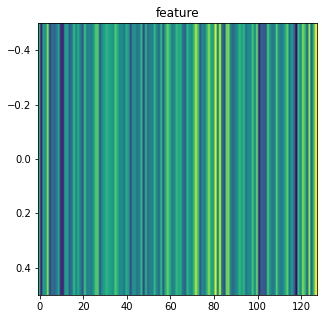

In [12]:
visualize('Boku_no_Hero_Academia_10')

As you can see, the mel spectrograms are more green in certain areas meaning that frequency concentrations are different in normal, intro, and outro sequences. We can also see that the feature scatterplots are shaped slightly different, with the outro and intro looking more alike and the normal different.

# Adaboost

The goal was to use adaboost to be a benchmark for further ml tactics. Turns out, adaboost works pretty well

In [13]:
valid_len = len(data)//5
train_len = len(data)-valid_len
valid, train = torch.utils.data.random_split(data, [valid_len, train_len])

In [14]:
len(train)

140

In [15]:
X,y=0,0
X_total = [t[0].cpu().numpy() for t in train]
y_total = [t[4] for t in train]

## training on one example

In [16]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_total[0], y_total[0])

AdaBoostClassifier(n_estimators=100, random_state=0)

### training acc

In [17]:
clf.score(X_total[0], y_total[0])

0.9564652371669915

### validation acc

In [18]:
clf.score(X_total[2], y_total[2])

0.8984737889847378

In [19]:
clf.score(X_total[3], y_total[3])

0.8860172299536117

## training on every point

In [38]:
def unroll(X):
    rX = []
    for x in X:
        for smolx in x:
            rX.append(smolx)
    return rX

In [21]:
X = unroll(X_total)
y = unroll(y_total)

In [22]:
np.array(X).shape

(210258, 128)

In [23]:
# uncomment if want to run instead of loading clf
# clf.fit(X,y)

In [24]:
# uncomment if want to save
# filename = 'adaboost.sav'
# pickle.dump(clf, open(filename, 'wb'))

In [25]:
filename = 'adaboost.sav'
clf = pickle.load(open(filename, 'rb'))

### training acc

In [26]:
# train acc
clf.score(X,y)

0.9348704924426181

### validation acc

In [27]:
# test
X_total_v = [t[0].cpu().numpy() for t in valid]
y_total_v = [t[4] for t in valid]
X_v = unroll(X_total_v)
y_v = unroll(y_total_v)
clf.score(X_v,y_v)

0.9322907716102423

## example of output

In [28]:
# params
plt.rcParams["figure.figsize"] = (20,1)

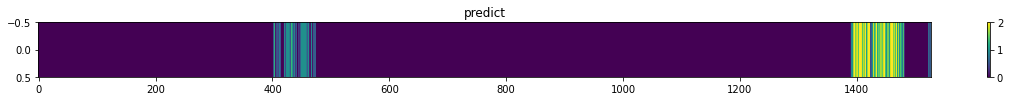

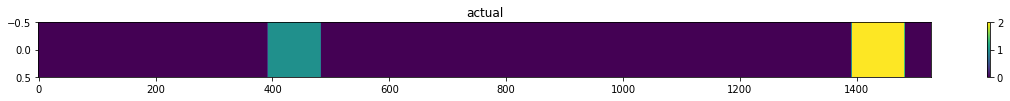

In [29]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(np.array(data.labels96[fn]).reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

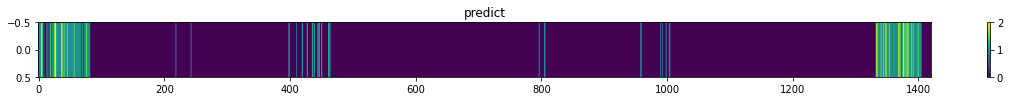

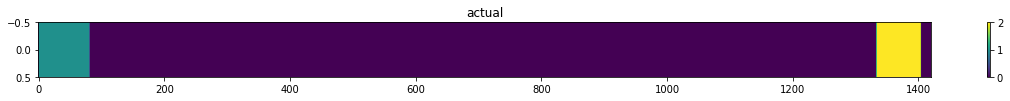

In [30]:
fn = 'Death_Note_21'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(np.array(data.labels96[fn]).reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

It is actually surprising that the classifier can tell between outros and intros. Upon listening, this is probably because outros tend to be softer and slower while intros are more aggressive. This is supported by the death note 21 wav file- Death Note's intro and outtro are more aggressive, so the classifier thinks that both are intros. This could be solved with a simple time test of whether the section is in the first or secound half of the episode. However, I think this should be done separate from adaboost (meaning afterward) b/c the time metric would be too strong for decision forests

# Using time

In [31]:
X_total_t = [t[0].cpu().numpy() for t in train]
X_time_t = [t[3].cpu().numpy() for t in train]
y_total_t = [t[4] for t in train]

In [32]:
X_t = unroll(X_total_t)
time_t = unroll(X_time_t)
y_t = unroll(y_total_t)

In [33]:
X_t = np.concatenate((X_t,time_t), axis=1)

In [34]:
X_t.shape

(210258, 129)

In [35]:
# uncomment if want to run instead of loading clf
# clf.fit(X_t,y_t)

In [36]:
# uncomment if saving
# filename = 'adaboost_time.sav'
# pickle.dump(clf, open(filename, 'wb'))

In [37]:
filename = 'adaboost_time.sav'
clf = pickle.load(open(filename, 'rb'))

### training acc

In [38]:
clf.score(X_t,y_t)

0.9280740804154896

### validation acc

In [39]:
X_total_tv = [t[0].cpu().numpy() for t in valid]
X_time_tv = [t[3].cpu().numpy() for t in valid]
y_total_tv = [t[4] for t in valid]
X_tv = unroll(X_total_tv)
time_tv = unroll(X_time_tv)
y_tv = unroll(y_total_tv)
X_tv = np.concatenate((X_tv,time_tv), axis=1)
clf.score(X_tv,y_tv)

0.9350403849458669

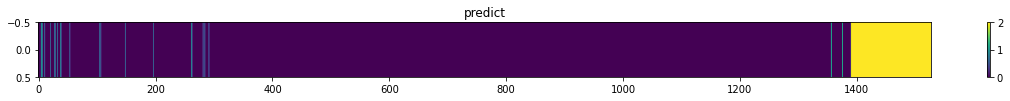

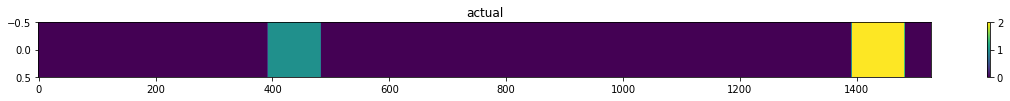

In [40]:
fn = 'Tokyo_Ghoul_9'
tv = np.concatenate((data.features[fn].cpu().numpy(),data.time[fn].cpu().numpy()), axis=1)
y = clf.predict(tv)

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(np.array(data.labels96[fn]).reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

I had the suspicion that training with time would not be good, and that intuition was correct. When it comes to decision trees, if there is one metric that is too powerful for too many examples, it would almost always be at the deciding factor at the top of the tree, reducing diversity. This is what happened to the example of Tokyo Ghoul 9, where it couldnt detect the intro at all because it was too far into the video. We can also see that the rest of the classifying besides the intro is more incorrect because the time metric is too powerful, thus reducing the power of a decision forest. This reduces our flexibility, so shouldn't be used. To explain the increase in accuracy, this is because the classifier can now accurately tell intros from outros for animes like Death Note 21 because of the time metric. In actuality, this doesnt matter because we can always post process and turn intros/outros into the correct one after adaboost classification with a simple time metric.

# outro/intro merge

with this is mind, let's try a scoring system where we do not differentiate between intro and outtro
 - test where we train with both labels but then turn them into one label in postprocess
 - test with train with only one label

## 1st option

In [41]:
def to_one(arr):
    return np.array(arr) >= 1

In [42]:
X,y=0,0
X_total = [t[0].cpu().numpy() for t in train]
y_total = [t[4] for t in train]
X = unroll(X_total)
y = unroll(y_total)
X_total_v = [t[0].cpu().numpy() for t in valid]
y_total_v = [t[4] for t in valid]
X_v = unroll(X_total_v)
y_v = unroll(y_total_v)

In [43]:
filename = 'adaboost.sav'
clf = pickle.load(open(filename, 'rb'))

benchmark

### benchmark accuracy

#### test

In [44]:
y_pred = clf.predict(X)
sklearn.metrics.accuracy_score(y_pred, y)
# should be same as above

0.9348704924426181

#### validation

In [45]:
y_v_pred = clf.predict(X_v)
sklearn.metrics.accuracy_score(y_v_pred, y_v)

0.9322907716102423

### no intro/outro distinction

#### test

In [47]:
y_one = to_one(y)
y_pred_one = to_one(y_pred)
sklearn.metrics.accuracy_score(y_pred_one, y_one)

0.9670214688620647

#### validation

In [48]:
y_v_one = to_one(y_v)
y_v_pred_one = to_one(y_v_pred)
sklearn.metrics.accuracy_score(y_v_pred_one, y_v_one)

0.9698879150674992

Here we find the missing accuracy from misclassifications of intro or outtro. We see an impressive improvment in accuracy score.

What I do find surprising, however, is that it seems the classifier can determine the difference between intros and outtros so well

### sidenote
Lets sidetrack here and see how well it can actually tell intros and outros. (From this point I am going to use the vocab 'inout' for intro/outros scenes). We have already determined that it can find inout scenes from non inout scenes. I think that the correct classification of non-inout scenes is bringing the percentage up and am curious to see how well within the inout scenes can this program determine.

In other words, we will measure the accuracy of the program only at intros and outros

In [37]:
def keep(y, y_pred):
    ry = []
    ry_pred = []
    for i in range(len(y_pred)):
        if y[i] > 0:
            ry.append(y[i])
            ry_pred.append(y_pred[i])
    return ry, ry_pred

In [50]:
ry, ry_pred = keep(y, y_pred)
print('inout score: ', sklearn.metrics.accuracy_score(ry, ry_pred))
print('no inout score:: ', sklearn.metrics.accuracy_score(to_one(ry), to_one(ry_pred)))

inout score:  0.5583425940625496
no inout score::  0.8266391490712811


So it doesn't do as well as expected, but if it was random, the classifier also has non-inout to choose from, meaning that it is a 33% mean accuracy on random guessing. However, if we assume that the classifier can guess from in or out, which it mostly does based on the visuals above, then the mean would be 50%. We will have to see how this accuracy is after smoothing/pooling.

If we are doing this we might as well record no inout differentiation score as well.

Lets see an example of one where it looks pretty good visually, like the 'Tokyo_Ghoul_9', and one where it doesn't look as good, like 'Death_Note_21'.

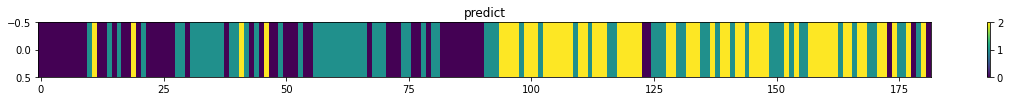

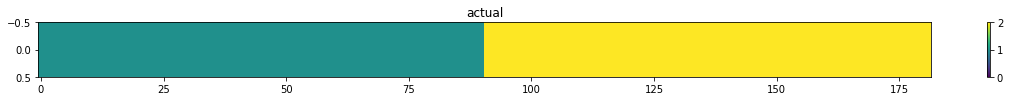

inout score:  0.5054945054945055
no inout score::  0.7032967032967034


In [51]:
fn = 'Tokyo_Ghoul_9'
y = np.array(data.labels96[fn])
y_pred = clf.predict(data.features[fn].cpu().numpy())
ry, ry_pred = keep(y, y_pred)

plt.title('predict')
plt.imshow(np.asarray(ry_pred).reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(np.asarray(ry).reshape((1,-1)), aspect='auto')
plt.clim(0,2)
plt.colorbar()
plt.show()

print('inout score: ', sklearn.metrics.accuracy_score(ry, ry_pred))
print('no inout score:: ', sklearn.metrics.accuracy_score(to_one(ry), to_one(ry_pred)))


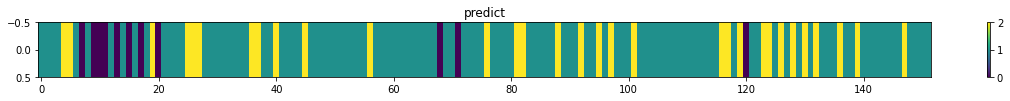

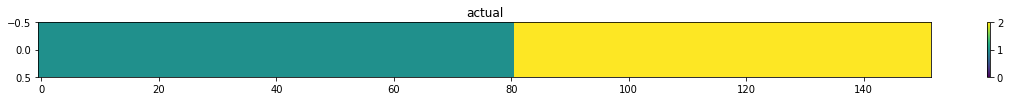

score:  0.5131578947368421
no inout score::  0.9276315789473685


In [52]:
fn = 'Death_Note_21'
y = np.array(data.labels96[fn])
y_pred = clf.predict(data.features[fn].cpu().numpy())
ry, ry_pred = keep(y, y_pred)

plt.title('predict')
plt.imshow(np.asarray(ry_pred).reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(np.asarray(ry).reshape((1,-1)), aspect='auto')
plt.clim(0,2)
plt.colorbar()
plt.show()

print('score: ', sklearn.metrics.accuracy_score(ry, ry_pred))
print('no inout score:: ', sklearn.metrics.accuracy_score(to_one(ry), to_one(ry_pred)))

## Option 2

In [53]:
X,y=0,0
X_total = [t[0].cpu().numpy() for t in train]
y_total = [t[4] for t in train]
X = unroll(X_total)
y = unroll(y_total)
X_total_v = [t[0].cpu().numpy() for t in valid]
y_total_v = [t[4] for t in valid]
X_v = unroll(X_total_v)
y_v = unroll(y_total_v)

In [54]:
y = to_one(y)
y_v = to_one(y_v)

In [55]:
# uncomment if training instead of loading
# clf.fit(X,y)

In [56]:
# uncomment if saving
# filename = 'adaboost_ones.sav'
# pickle.dump(clf, open(filename, 'wb'))

In [57]:
filename = 'adaboost_ones.sav'
clf = pickle.load(open(filename, 'rb'))

#### test

In [58]:
clf.score(X,y)

0.9666314718108229

#### validation

In [59]:
clf.score(X_v,y_v)

0.9684940138626339

Score seems close enough that the difference doesn't really matter whether you train on inout as separate or together

# Sliding window

This adaboost classifier works surprisingly well, but can use some improvements. Perhaps a sliding pooling window using averaging or voting.

In [60]:
# y_v_one
# y_v_pred_one

In [61]:
def sliding_avg(arr, window_len):
    start = 0
    end = window_len
    wsum = sum(arr[start:end])
    wsum_arr = []
    wsum_arr.append(wsum/window_len)
    while end != len(arr):
        wsum -= arr[start]
        wsum += arr[end]
        start += 1
        end += 1
        wsum_arr.append(wsum/window_len)
    return wsum_arr

In [62]:
filename = 'adaboost.sav'
clf = pickle.load(open(filename, 'rb'))

## benchmark w/ no sliding window

### test

In [63]:
# benchmark
sklearn.metrics.accuracy_score(y_pred_one, y_one)

0.9670214688620647

### valid

In [64]:
# benchmark
sklearn.metrics.accuracy_score(y_v_pred_one, y_v_one)

0.9698879150674992

## w/ sliding window

Let's calculate our new predictions after using a sliding average

In [65]:
def avg_new(arr, window_len):
    # one function to do buffering, averaging, and rounding all
    assert window_len%2 == 1 # please use odd numbers
    buffer= [0]*(window_len//2)
    buffered = np.concatenate((buffer,arr,buffer))
    return np.round(sliding_avg(buffered, window_len))

In [66]:
# size 11 window is arbitrary
y_pred_one_new = avg_new(y_pred_one, 11)

### test acc

In [67]:
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9836819526486507

### valid acc

In [68]:
y_v_pred_one_new = avg_new(y_v_pred_one, 11)
sklearn.metrics.accuracy_score(y_v_pred_one_new, y_v_one)

0.9839414943384698

This is indeed higher. I have to wonder if there is a problem because the songs are stacked directly on each other with no buffer. This will be time consuming to test and I will leave it to later because I don't think that the stacking without buffer is negatively affecting our predictions much.

Let's see some examples

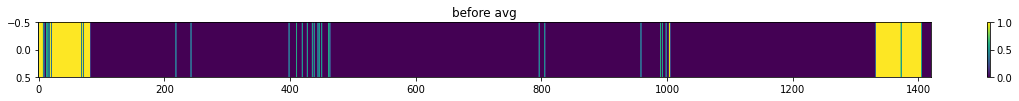

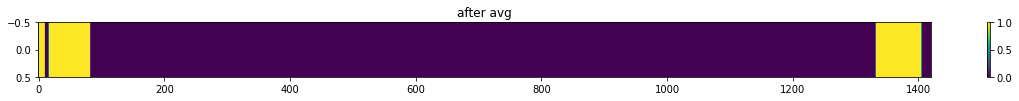

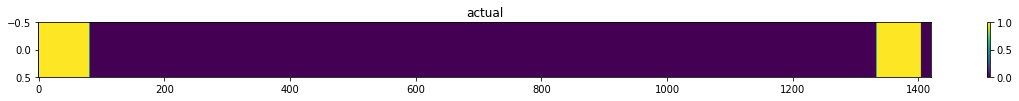

score before avg:  0.9753694581280788
score after avg:  0.9936664320900774


In [69]:
fn = 'Death_Note_21'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(np.array(data.labels96[fn]))

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

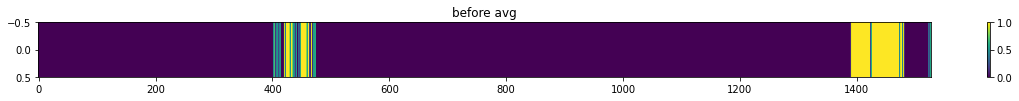

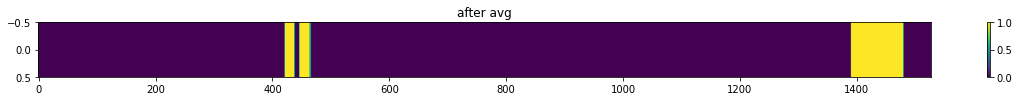

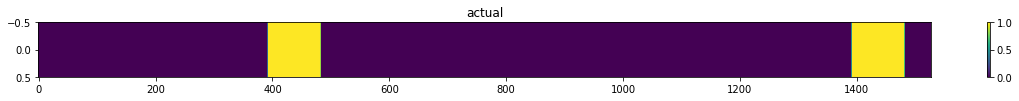

score before avg:  0.962696335078534
score after avg:  0.9620418848167539


In [70]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(np.array(data.labels96[fn]))

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

Well obviously 11 may not be the best window. It might also be best to change the rounding algorithm to be more leniant

In [71]:
# add a new cutoff
def avg_new(arr, window_len, cutoff=.5):
    # one function to do buffering, averaging, and rounding all
    assert window_len%2 == 1 # please use odd numbers
    buffer= [0]*(window_len//2)
    buffered = np.concatenate((buffer,arr,buffer))
    avg = sliding_avg(buffered, window_len)
    return np.array([1 if i>cutoff else 0 for i in avg])

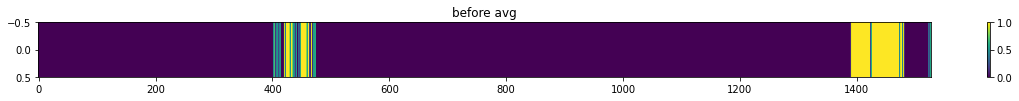

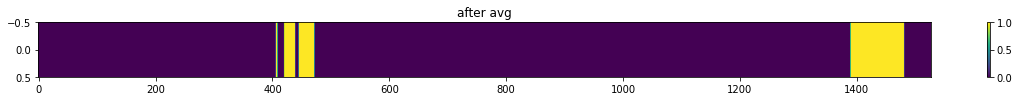

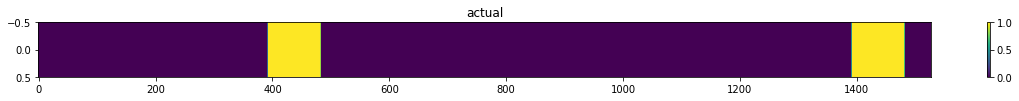

score before avg:  0.962696335078534
score after avg:  0.9705497382198953


In [72]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(np.array(data.labels96[fn]))

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11,.4)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

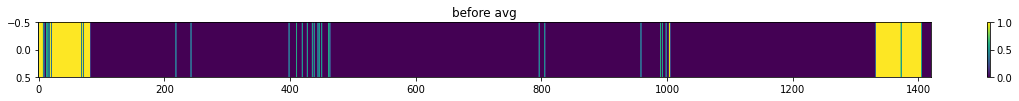

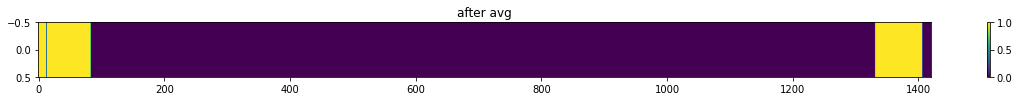

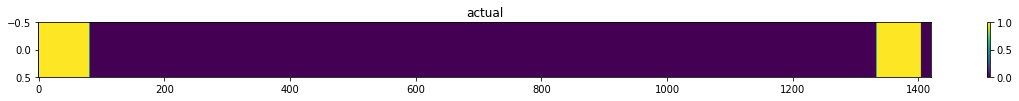

score before avg:  0.9753694581280788
score after avg:  0.9943701618578465


In [73]:
fn = 'Death_Note_21'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(np.array(data.labels96[fn]))

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11,.4)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

After some testing, it seems that a .3-.4 ish for cutoff is a good value that isn't too aggressive at cutting off noise and not too lenient to misunderstand noise as intro/outro

In [74]:
y_pred_one_new = avg_new(y_pred_one, 11, .3)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9849042604799817

In [75]:
y_pred_one_new = avg_new(y_pred_one, 11, .4)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.985532060611249

In [76]:
y_pred_one_new = avg_new(y_pred_one, 11, .5)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9836819526486507

It might be better to have something more leniant, then use the information that we know we have at most 2 big continuous chunks to group it all together.

# "Neural Networks"

I'm actually curious how a neural network would do on this problem after being given the vggish features. We can think of this as transfer learning where we are freezing the layers extracting the features. In this case we can encorporate time as a feature to see if it helps

The way the data was stored was meant of NN training anyways

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class simpleNN(nn.Module):
    def __init__(self, fsize, H, out):
        super(simpleNN, self).__init__()
        self.linear1 = torch.nn.Linear(fsize, H)
        self.linear2 = torch.nn.Linear(H, out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred     

In [5]:
# first train without time
model = simpleNN(128, 50, 2).cuda()

# 12% of data is intro or outro
weight = torch.tensor([.14,.86])

# weighted training. TODO: train w/ and w/o weights. w/o weights will be more analogous to adaboost
criterion = nn.CrossEntropyLoss(weight).cuda()
# criterion = nn.CrossEntropyLoss().cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [6]:
valid_len = len(data)//5
train_len = len(data)-valid_len
valid, train = torch.utils.data.random_split(data, [valid_len, train_len])

In [46]:
for epoch in range(1):
    
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in train:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5
            
            optimizer.zero_grad()
            
            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output, l)
            loss = criterion(output, l)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if j % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, j + 1, running_loss / 2000))
                running_loss = 0.0
            j+=1
print('fin')
        

[1,  2000] loss: 0.582
[1,  4000] loss: 0.389
[1,  6000] loss: 0.360
[1,  8000] loss: 0.309
[1, 10000] loss: 0.239
[1, 12000] loss: 0.251
[1, 14000] loss: 0.265
[1, 16000] loss: 0.181
[1, 18000] loss: 0.215
[1, 20000] loss: 0.201
[1, 22000] loss: 0.135
[1, 24000] loss: 0.180
[1, 26000] loss: 0.172
[1, 28000] loss: 0.122
[1, 30000] loss: 0.138
[1, 32000] loss: 0.149
[1, 34000] loss: 0.179
[1, 36000] loss: 0.150
[1, 38000] loss: 0.154
[1, 40000] loss: 0.090
[1, 42000] loss: 0.113
[1, 44000] loss: 0.120
[1, 46000] loss: 0.060
[1, 48000] loss: 0.119
[1, 50000] loss: 0.124
[1, 52000] loss: 0.086
[1, 54000] loss: 0.091
[1, 56000] loss: 0.104
[1, 58000] loss: 0.066
[1, 60000] loss: 0.079
[1, 62000] loss: 0.118
[1, 64000] loss: 0.085
[1, 66000] loss: 0.106
[1, 68000] loss: 0.117
[1, 70000] loss: 0.095
[1, 72000] loss: 0.080
[1, 74000] loss: 0.154
[1, 76000] loss: 0.107
[1, 78000] loss: 0.125
[1, 80000] loss: 0.087
[1, 82000] loss: 0.058
[1, 84000] loss: 0.056
[1, 86000] loss: 0.112
[1, 88000] 

In [58]:
torch.save(model.state_dict(), './models_pth/weighted_ones.pth')

In [55]:
y_total_v = [t[4] for t in valid]
y_v = unroll(y_total_v)

In [56]:
output_nn = np.empty(len(y_v))
with torch.no_grad():
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in valid:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5

            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output[0].cpu().numpy(), l)
            pred = 0
            if output[0][0] < output[0][1]:
                pred = 1
            output_nn[j] = pred
            loss = criterion(output, l)

            running_loss += loss.item()
            j+=1
    print (running_loss/j)


0.09269816006955132


In [57]:
sklearn.metrics.accuracy_score(output_nn, y_v)

0.9166112893732556

## no weight training criterion

In [59]:
# first train without time
model = simpleNN(128, 50, 2).cuda()

# 12% of data is intro or outro
weight = torch.tensor([.14,.86])

# no weighted training. TODO: train w/ and w/o weights. w/o weights will be more analogous to adaboost
# criterion = nn.CrossEntropyLoss(weight).cuda()
criterion = nn.CrossEntropyLoss().cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [60]:
for epoch in range(1):
    
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in train:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5
            
            optimizer.zero_grad()
            
            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output, l)
            loss = criterion(output, l)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if j % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, j + 1, running_loss / 2000))
                running_loss = 0.0
            j+=1
print('fin')
        

[1,  2000] loss: 0.569
[1,  4000] loss: 0.383
[1,  6000] loss: 0.354
[1,  8000] loss: 0.305
[1, 10000] loss: 0.241
[1, 12000] loss: 0.256
[1, 14000] loss: 0.259
[1, 16000] loss: 0.174
[1, 18000] loss: 0.217
[1, 20000] loss: 0.193
[1, 22000] loss: 0.134
[1, 24000] loss: 0.183
[1, 26000] loss: 0.169
[1, 28000] loss: 0.120
[1, 30000] loss: 0.136
[1, 32000] loss: 0.148
[1, 34000] loss: 0.175
[1, 36000] loss: 0.148
[1, 38000] loss: 0.154
[1, 40000] loss: 0.089
[1, 42000] loss: 0.114
[1, 44000] loss: 0.122
[1, 46000] loss: 0.060
[1, 48000] loss: 0.119
[1, 50000] loss: 0.123
[1, 52000] loss: 0.084
[1, 54000] loss: 0.091
[1, 56000] loss: 0.103
[1, 58000] loss: 0.065
[1, 60000] loss: 0.080
[1, 62000] loss: 0.118
[1, 64000] loss: 0.085
[1, 66000] loss: 0.108
[1, 68000] loss: 0.114
[1, 70000] loss: 0.096
[1, 72000] loss: 0.080
[1, 74000] loss: 0.154
[1, 76000] loss: 0.108
[1, 78000] loss: 0.129
[1, 80000] loss: 0.087
[1, 82000] loss: 0.058
[1, 84000] loss: 0.056
[1, 86000] loss: 0.113
[1, 88000] 

In [61]:
torch.save(model.state_dict(), './models_pth/nonweighted_ones.pth')

In [62]:
output_nn = np.empty(len(y_v))
with torch.no_grad():
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in valid:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5

            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output[0].cpu().numpy(), l)
            pred = 0
            if output[0][0] < output[0][1]:
                pred = 1
            output_nn[j] = pred
            loss = criterion(output, l)

            running_loss += loss.item()
            j+=1
    print (running_loss/j)


0.09284736306235161


In [63]:
sklearn.metrics.accuracy_score(output_nn, y_v)

0.9165353433708633

## more layers?

In [31]:
class TNN(nn.Module):
    def __init__(self, fsize, H1, H2, H3, H4, out):
        super(TNN, self).__init__()
        self.linear1 = torch.nn.Linear(fsize, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, H3)
        self.linear4 = torch.nn.Linear(H3, H4)
        self.linear5 = torch.nn.Linear(H4, out)
    
    def forward(self, x):
        x = self.linear1(x).clamp(min=0)
        x = self.linear2(x).clamp(min=0)
        x = self.linear3(x).clamp(min=0)
        x = self.linear4(x).clamp(min=0)
        y_pred = self.linear5(x)
        return y_pred     

In [32]:
# first train without time
model = TNN(128, 90, 60, 30, 10, 2).cuda()
 
# 12% of data is intro or outro
weight = torch.tensor([.14,.86])

# weighted training. TODO: train w/ and w/o weights. w/o weights will be more analogous to adaboost
criterion = nn.CrossEntropyLoss(weight).cuda()
# criterion = nn.CrossEntropyLoss().cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
valid_len = len(data)//5
train_len = len(data)-valid_len
valid, train = torch.utils.data.random_split(data, [valid_len, train_len])

In [34]:
for epoch in range(1):
    
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in train:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5
            
            optimizer.zero_grad()
            
            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output, l)
            loss = criterion(output, l)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if j % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, j + 1, running_loss / 2000))
                running_loss = 0.0
            j+=1
print('fin')
        

[1,  2000] loss: 0.263
[1,  4000] loss: 0.063
[1,  6000] loss: 0.120
[1,  8000] loss: 0.068
[1, 10000] loss: 0.055
[1, 12000] loss: 0.075
[1, 14000] loss: 0.051
[1, 16000] loss: 0.064
[1, 18000] loss: 0.036
[1, 20000] loss: 0.097
[1, 22000] loss: 0.044
[1, 24000] loss: 0.096
[1, 26000] loss: 0.062
[1, 28000] loss: 0.026
[1, 30000] loss: 0.055
[1, 32000] loss: 0.088
[1, 34000] loss: 0.200
[1, 36000] loss: 0.158
[1, 38000] loss: 0.118
[1, 40000] loss: 0.077
[1, 42000] loss: 0.033
[1, 44000] loss: 0.068
[1, 46000] loss: 0.096
[1, 48000] loss: 0.052
[1, 50000] loss: 0.085
[1, 52000] loss: 0.204
[1, 54000] loss: 0.117
[1, 56000] loss: 0.065
[1, 58000] loss: 0.052
[1, 60000] loss: 0.117
[1, 62000] loss: 0.051
[1, 64000] loss: 0.049
[1, 66000] loss: 0.100
[1, 68000] loss: 0.056
[1, 70000] loss: 0.041
[1, 72000] loss: 0.061
[1, 74000] loss: 0.087
[1, 76000] loss: 0.051
[1, 78000] loss: 0.082
[1, 80000] loss: 0.068
[1, 82000] loss: 0.025
[1, 84000] loss: 0.109
[1, 86000] loss: 0.074
[1, 88000] 

In [39]:
torch.save(model.state_dict(), './models_pth/5_layers.pth')

In [40]:
y_total_v = [t[4] for t in valid]
y_v = unroll(y_total_v)

In [41]:
output_nn = np.empty(len(y_v))
with torch.no_grad():
    j=0
    running_loss = 0.0
    # feature, mel-spectrogram (log), labels, time, labels96
    for feature,_,_,_,labels96 in valid:
        for i in range(len(feature)):
            f = feature[i]
            temp = 0
            if labels96[i]>=1:
                temp = 1
            l = torch.tensor([temp]).cuda()
            f = f/255 -.5

            # output = torch.reshape(model(f),(1,-1))
            output = model(torch.reshape(f,(1,-1)))
#             print (output[0].cpu().numpy(), l)
            pred = 0
            if output[0][0] < output[0][1]:
                pred = 1
            output_nn[j] = pred
            loss = criterion(output, l)

            running_loss += loss.item()
            j+=1
    print (running_loss/j)


0.20462060075303673


In [42]:
sklearn.metrics.accuracy_score(output_nn, y_v)

0.8963971631205674

In [ ]:
model.eval()
with torch.no_grad():
    rv = predict("data/Audio/Boku_no_Hero_Academia_10.wav", net)